In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load and merge data
customer_info = pd.read_csv('CustomerInfo2.csv')
product_info = pd.read_csv('ProductInfo.csv')
df = pd.merge(customer_info, product_info, on='CustomerID')

# Encode categorical variables
cat_cols = ['Gender', 'Location', 'HighestEducation', 'Profession', 'LastProductPurchased']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Prepare features and target
feature_cols = ['Age', 'Gender', 'Income', 'Location', 'HighestEducation', 'CreditScore', 'Profession', 'DisposableIncome']
product_cols = [col for col in df.columns if col.endswith('_Owned')]

X = df[feature_cols]
y = df[product_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
y

,PersonalLoan_Owned,HomeLoan_Owned,VehicleLoan_Owned,EducationLoan_Owned,Insurance_Owned,VehicleInsurance_Owned,MutualFund_Owned,FixedDeposit_Owned
0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,1
2,0,0,1,0,0,0,0,1
3,0,0,1,0,0,1,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
9995,0,0,1,0,0,1,1,0
9996,1,0,0,0,0,0,0,1
9997,0,0,1,0,1,1,0,0
9998,1,0,0,0,0,0,1,0


In [14]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100
}

# Create and train the multi-output XGBoost model
model = MultiOutputClassifier(xgb.XGBClassifier(**params))
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.2127
Recall: 0.0065
F1 Score: 0.0126


In [18]:
# Feature importance
feature_importance = np.mean([estimator.feature_importances_ for estimator in model.estimators_], axis=0)
feature_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)


Feature Importance:
            feature  importance
7  DisposableIncome    0.139045
2            Income    0.137013
5       CreditScore    0.133669
0               Age    0.125148
6        Profession    0.119443
4  HighestEducation    0.117142
3          Location    0.115569
1            Gender    0.112970


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y = df['LastProductPurchased']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set XGBoost parameters for multi-class classification
params = {
    'objective': 'multi:softprob',  # Use softprob to get probabilities for each class
    'eval_metric': 'mlogloss',      # Multi-class logloss
    'num_class': len(le.classes_),  # Number of classes
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100
}

# Create and train the XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Feature importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)


Accuracy: 0.1205
Precision: 0.1211
Recall: 0.1205
F1 Score: 0.1202

Feature Importance:
            feature  importance
7  DisposableIncome    0.137452
2            Income    0.136078
5       CreditScore    0.134490
0               Age    0.124778
4  HighestEducation    0.118156
6        Profession    0.117379
3          Location    0.116034
1            Gender    0.115633


In [25]:
def get_next_product(row):
    products = ['PersonalLoan', 'HomeLoan', 'VehicleLoan', 'EducationLoan', 'Insurance', 'VehicleInsurance', 'MutualFund', 'FixedDeposit']
    owned_products = [p for p in products if row[f'{p}_Owned'] == 1]
    available_products = [p for p in products if p not in owned_products]
    return np.random.choice(available_products) if available_products else None

df['NextProductPurchased'] = df.apply(get_next_product, axis=1)
df = df.dropna(subset=['NextProductPurchased'])

# Encode the target variable
df['NextProductPurchased'] = le.fit_transform(df['NextProductPurchased'])

In [28]:
#checking for sanity of our new column
df[df['LastProductPurchased']==df['NextProductPurchased']]

,CustomerID,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,...,Insurance_Owned,Insurance_Amount,VehicleInsurance_Owned,VehicleInsurance_Amount,MutualFund_Owned,MutualFund_Amount,FixedDeposit_Owned,FixedDeposit_Amount,LastProductPurchased,NextProductPurchased


In [33]:
feature_cols

['Age',
 'Gender',
 'Income',
 'Location',
 'HighestEducation',
 'CreditScore',
 'Profession',
 'DisposableIncome',
 'LastProductPurchased']

In [35]:
# Create new features
df['TotalLoanAmount'] = df['PersonalLoan_Amount'] + df['HomeLoan_Amount'] + df['VehicleLoan_Amount'] + df['EducationLoan_Amount']
df['TotalInsuranceAmount'] = df['Insurance_Amount'] + df['VehicleInsurance_Amount']
df['TotalInvestmentAmount'] = df['MutualFund_Amount'] + df['FixedDeposit_Amount']

# Select features for the model
features = ['Age', 'Gender', 'Location', 'HighestEducation', 'Income', 'CreditScore', 'Profession', 'DisposableIncome',
            'TotalLoanAmount', 'TotalInsuranceAmount', 'TotalInvestmentAmount', 'LastProductPurchased']

X = df[features]
y = df['NextProductPurchased']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Initialize and train the model
model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    tree_method='hist',  # For better interpretability
    random_state=42
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [39]:
from sklearn.metrics import accuracy_score, classification_report

Accuracy: 0.1675

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.04      0.06       230
           1       0.18      0.10      0.13       264
           2       0.18      0.45      0.26       256
           3       0.16      0.17      0.17       261
           4       0.15      0.22      0.18       244
           5       0.16      0.09      0.12       245
           6       0.15      0.09      0.12       243
           7       0.18      0.16      0.17       257

    accuracy                           0.17      2000
   macro avg       0.16      0.17      0.15      2000
weighted avg       0.16      0.17      0.15      2000


Feature Importance:
LastProductPurchased: 0.2028
TotalLoanAmount: 0.1501
TotalInsuranceAmount: 0.1452
TotalInvestmentAmount: 0.1237
HighestEducation: 0.0542
CreditScore: 0.0538
DisposableIncome: 0.0496
Income: 0.0485
Profession: 0.0482
Location: 0.0457
Gender: 0.0402
Age: 0.0380


<Figure size 1000x600 with 0 Axes>

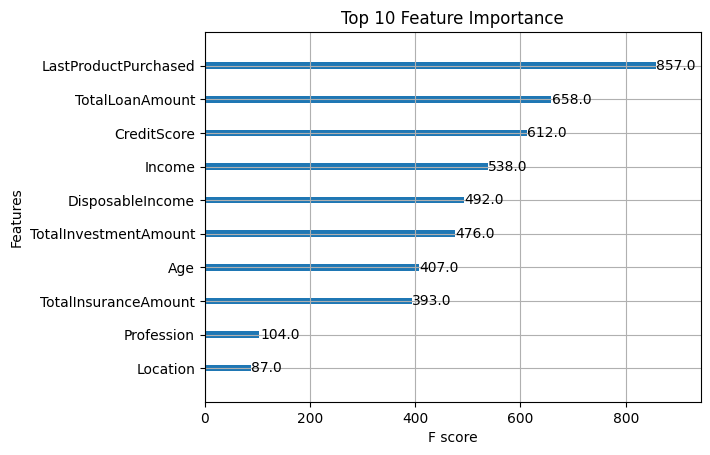

In [40]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = model.feature_importances_
feature_importance_dict = dict(zip(features, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")

# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.show()

In [45]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

ImportError: cannot import name 'threadpool_info' from 'sklearn.utils.fixes' (/opt/anaconda3/envs/recsys/lib/python3.11/site-packages/sklearn/utils/fixes.py)